# 7-共享单车数据社区发现

对于共享单车的出行，每一次出行都可以被看作是一个从起点行动到终点的出行过程。当我们把起点和终点视为节点，把它们之间的出行视为边时，就可以构建一个网络。通过分析这个网络，我们可以得到关于城市的空间结构、共享单车需求的宏观出行特征等信息。
社区发现，也可以叫图分割，帮助我们揭示网络中节点之间的隐藏关系。在这个例子中，我们将介绍如何将TransBigData整合到共享单车数据的社区发现分析过程中。

## 数据预处理

在社区发现之前，我们首先需要对数据进行预处理。从共享单车订单中提取出行OD并剔除异常出行，并以清洗好的数据作为研究对象。

In [1]:
import pandas as pd
import geopandas as gpd
import transbigdata as tbd

In [2]:
#读取共享单车数据
bikedata = pd.read_csv(r'../../../example/data/bikedata-sample.csv')
bikedata.head(5)

BIKE_ID           DATA_TIME  LOCK_STATUS   LONGITUDE   LATITUDE
0        5  2018-09-01 0:00:36            1  121.363566  31.259615
1        6  2018-09-01 0:00:50            0  121.406226  31.214436
2        6  2018-09-01 0:03:01            1  121.409402  31.215259
3        6  2018-09-01 0:24:53            0  121.409228  31.214427
4        6  2018-09-01 0:26:38            1  121.409771  31.214406

In [3]:
#读取上海行政区划边界
shanghai_admin = gpd.read_file(r'../../../example/data/shanghai.json')
#剔除研究范围外的数据
bikedata = tbd.clean_outofshape(bikedata, shanghai_admin, col=['LONGITUDE', 'LATITUDE'], accuracy=500)

从单车数据中识别出行OD信息`tbd.bikedata_to_od`

In [4]:
#识别单车出行OD
move_data,stop_data = tbd.bikedata_to_od(bikedata,
                   col = ['BIKE_ID','DATA_TIME','LONGITUDE','LATITUDE','LOCK_STATUS'])
move_data.head(5)

BIKE_ID                stime        slon       slat  \
96          6   2018-09-01 0:00:50  121.406226  31.214436   
561         6   2018-09-01 0:24:53  121.409228  31.214427   
564         6   2018-09-01 0:50:16  121.409727  31.214403   
784         6   2018-09-01 0:53:38  121.413333  31.214951   
1028        6  2018-09-01 11:35:01  121.419261  31.213414   

                    etime        elon       elat  
96     2018-09-01 0:03:01  121.409402  31.215259  
561    2018-09-01 0:26:38  121.409771  31.214406  
564    2018-09-01 0:52:14  121.412610  31.214905  
784    2018-09-01 0:55:38  121.412656  31.217051  
1028  2018-09-01 11:35:13  121.419518  31.213657

我们需要剔除过长与过短的共享单车出行。用tbd.getdistance获取起终点之间的直线距离，并筛选删除直线距离小于100米与大于10千米的出行

In [5]:
#计算骑行直线距离
move_data['distance'] = tbd.getdistance(move_data['slon'],move_data['slat'],move_data['elon'],move_data['elat'])
#清洗骑行数据，删除过长与过短的出行
move_data = move_data[(move_data['distance']>100)&(move_data['distance']<10000)]

接下来，我们以500米×500米的栅格为最小分析单元，用tbd.grid_params方法获取栅格划分参数，再将参数输入tbd.odagg_grid方法，对OD进行栅格集计

In [6]:
#获取栅格参数
bounds = (120.85, 30.67, 122.24, 31.87)
params = tbd.area_to_params(bounds,accuracy = 500)
#集计OD
od_gdf = tbd.odagg_grid(move_data, params, col=['slon', 'slat', 'elon', 'elat'])
od_gdf.head(5)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:91: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


SLONCOL  SLATCOL  ELONCOL  ELATCOL  count      SHBLON     SHBLAT  \
0           26       95       26       96      1  120.986782  31.097177   
40803      117      129      116      127      1  121.465519  31.250062   
40807      117      129      117      128      1  121.465519  31.250062   
40810      117      129      117      131      1  121.465519  31.250062   
40811      117      129      118      126      1  121.465519  31.250062   

           EHBLON     EHBLAT  \
0      120.986782  31.101674   
40803  121.460258  31.241069   
40807  121.465519  31.245565   
40810  121.465519  31.259055   
40811  121.470780  31.236572   

                                                geometry  
0      LINESTRING (120.98678 31.09718, 120.98678 31.1...  
40803  LINESTRING (121.46552 31.25006, 121.46026 31.2...  
40807  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40810  LINESTRING (121.46552 31.25006, 121.46552 31.2...  
40811  LINESTRING (121.46552 31.25006, 121.47078 31.2...

对OD集计的结果在地图上可视化，用tbd.plot_map加载地图底图，并用tbd.plotscale添加比例尺与指北针

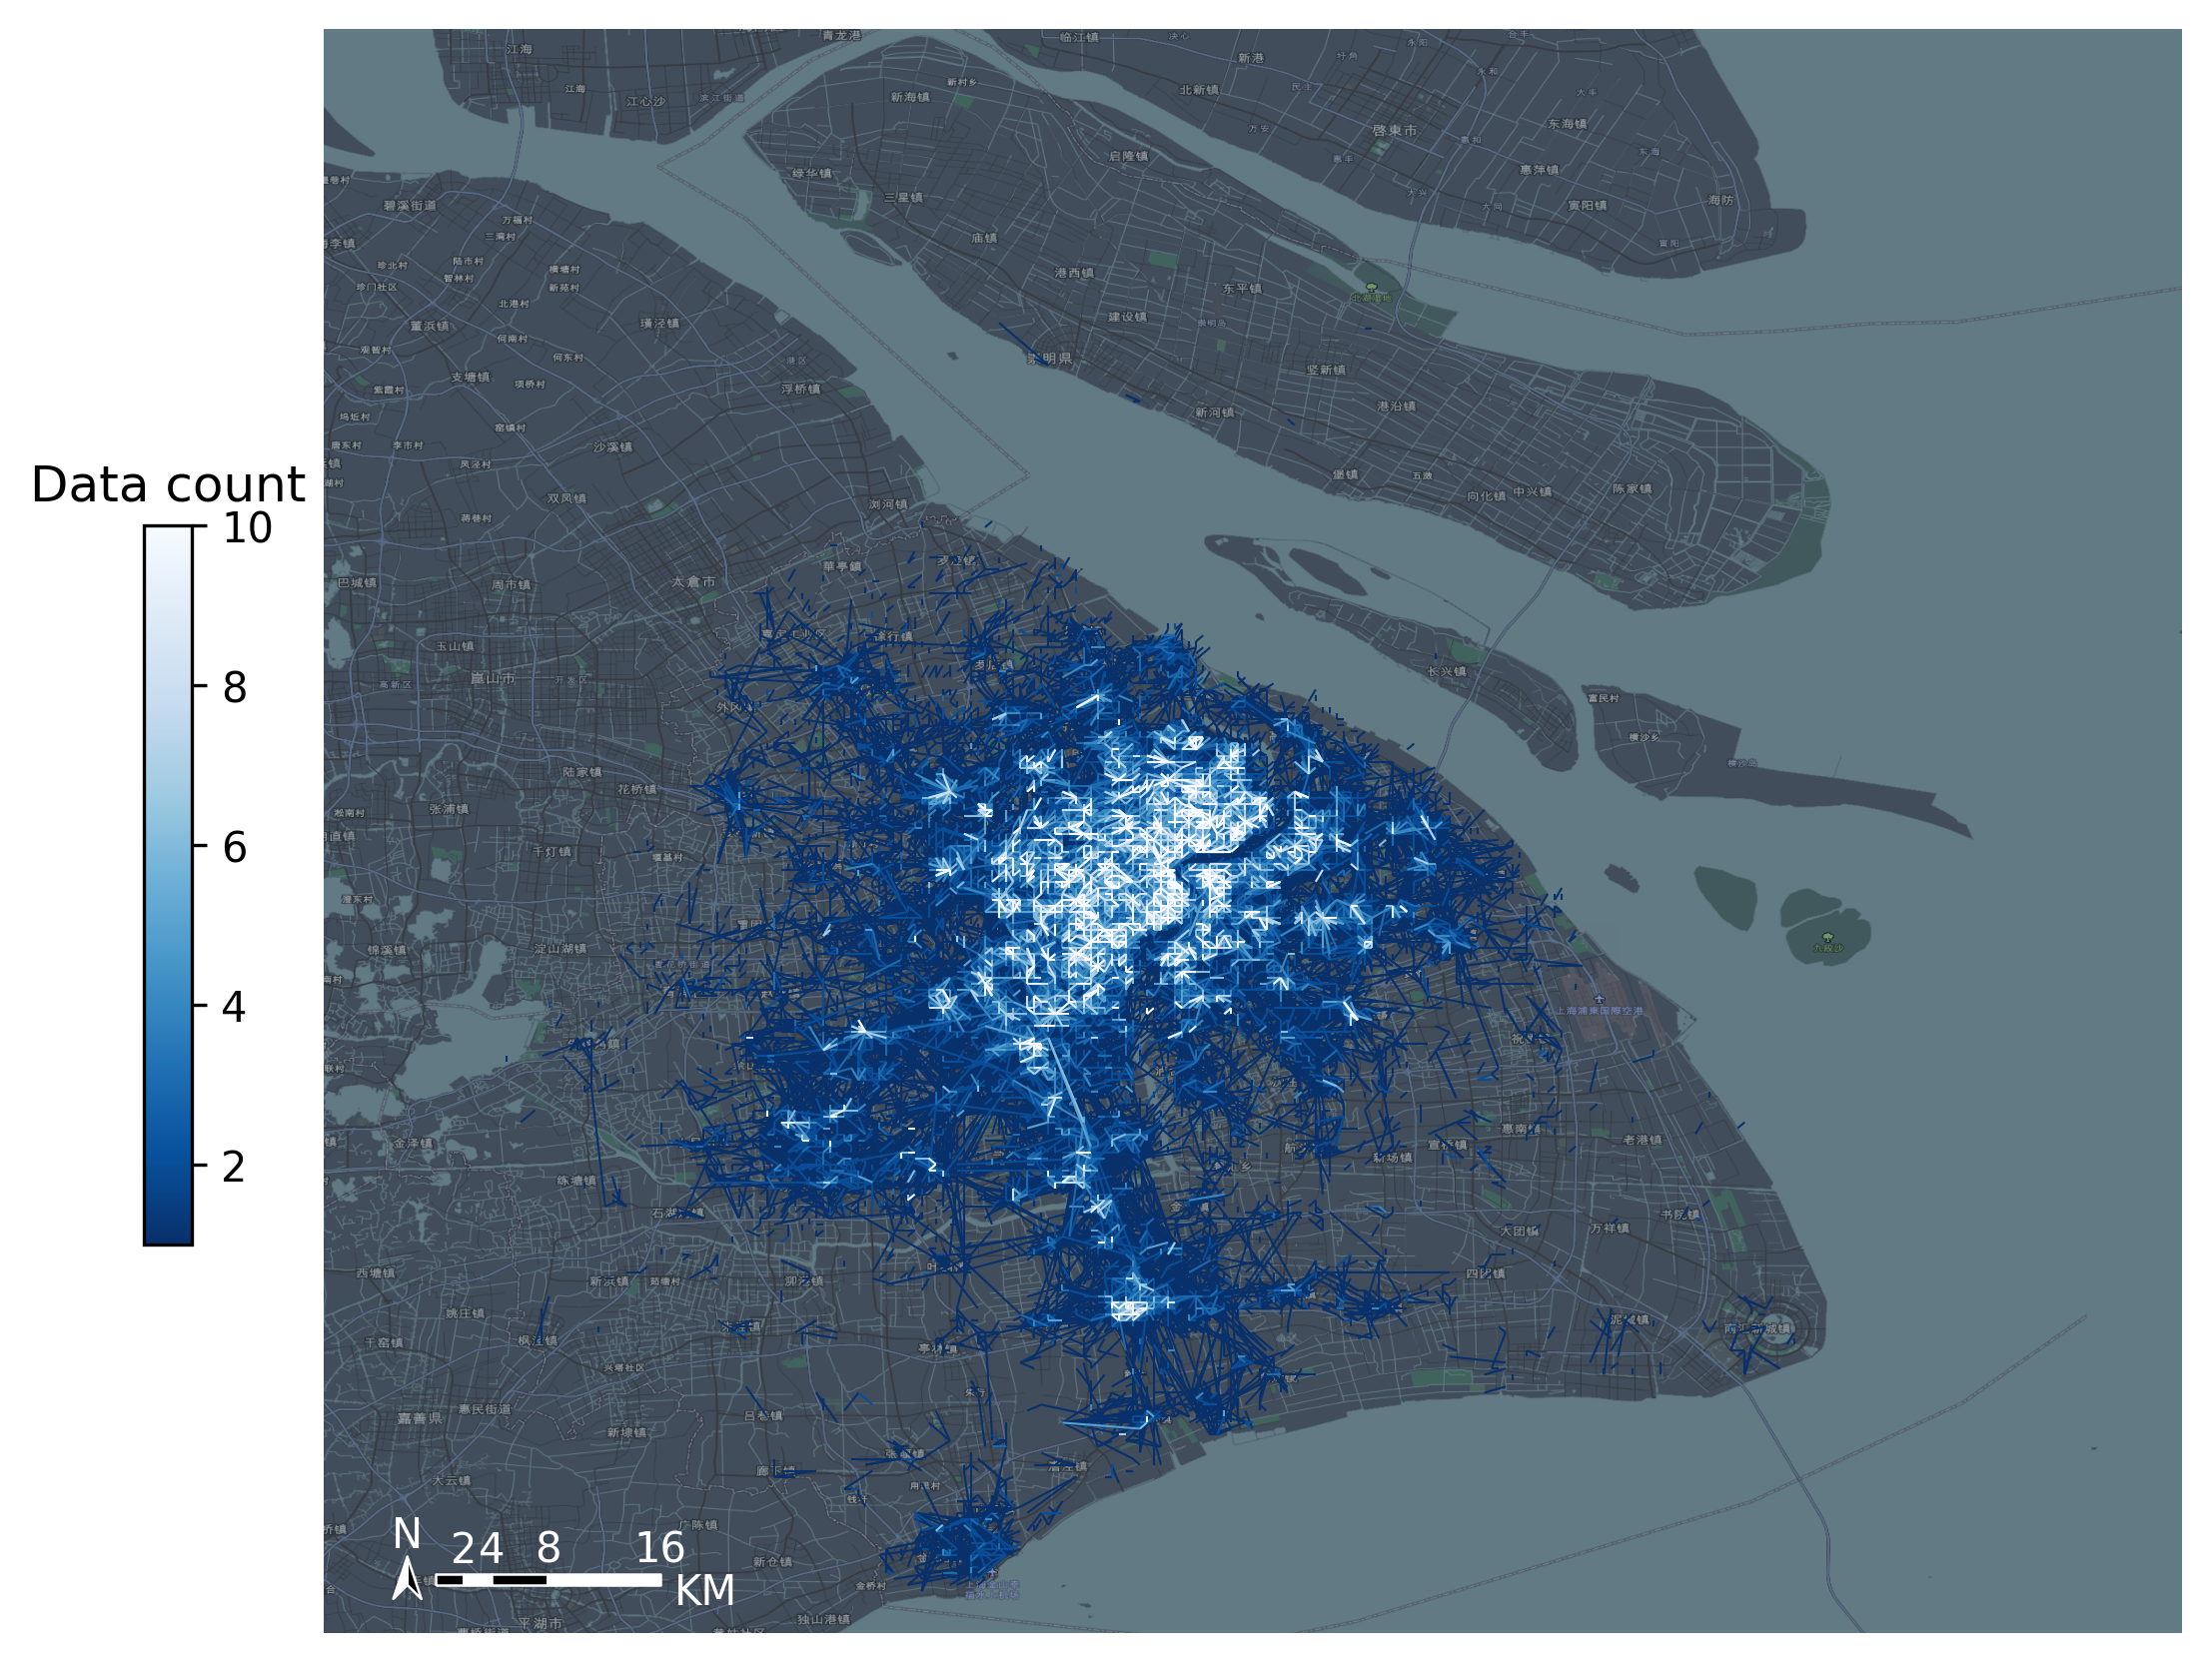

In [7]:
#创建图框
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)

#添加地图底图
tbd.plot_map(plt,bounds,zoom = 11,style = 8)

#绘制colorbar
cax = plt.axes([0.05, 0.33, 0.02, 0.3])
plt.title('Data count')
plt.sca(ax)

#绘制OD
od_gdf.plot(ax = ax,column = 'count',cmap = 'Blues_r',linewidth = 0.5,vmax = 10,cax = cax,legend = True)

#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'white',accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()

## 构建网络

### 提取节点信息

使用igraph包构建网络。在Python中，igraph与networkx功能类似，都提供了网络分析的功能，仅在部分算法的支持上有所区别。 构建网络时，我们需要向igraph提供网络的节点与边的信息。以OD数据中出现过的每个栅格作为节点，构建节点的信息时，需要为节点创建从0开始的数字编号，代码如下


In [8]:
#把起终点的经纬度栅格编号变为一个字段
od_gdf['S'] = od_gdf['SLONCOL'].astype(str) + ',' + od_gdf['SLATCOL'].astype(str)
od_gdf['E'] = od_gdf['ELONCOL'].astype(str) + ',' + od_gdf['ELATCOL'].astype(str)
#提取节点集合
node = set(od_gdf['S'])|set(od_gdf['E'])
#把节点集合变成DataFrame
node = pd.DataFrame(node)
#重新编号节点
node['id'] = range(len(node))
node

0    id
0      150,91     0
1     112,151     1
2     154,119     2
3      57,157     3
4     128,117     4
...       ...   ...
9806    91,16  9806
9807  119,110  9807
9808   86,114  9808
9809   123,86  9809
9810    62,73  9810

[9811 rows x 2 columns]

### 提取边信息

将新的编号连接到OD信息表上，以提取新ID之间的出行量构成边

In [9]:
#把新编号连接到OD数据上
node.columns = ['S','S_id']
od_gdf = pd.merge(od_gdf,node,on = ['S'])
node.columns = ['E','E_id']
od_gdf = pd.merge(od_gdf,node,on = ['E'])
#提取边信息
edge = od_gdf[['S_id','E_id','count']]
edge

S_id  E_id  count
0      4666   700      1
1      2508  7322      1
2       787  7322      3
3      5865  7322      1
4      6386  7322      1
...     ...   ...    ...
68468  5450  1796      2
68469  2935  2036      2
68470   604  8816      2
68471   398  6426      3
68472  9323  5790      3

[68473 rows x 3 columns]

### 构建网络

导入igraph包，创建网络，添加节点，并将边数据输入网络。同时，为每一条边添加相应的权重

In [10]:
import igraph
#创建网络
g = igraph.Graph()
g.add_vertices(len(node))
g.add_edges(edge[['S_id','E_id']].values)
edge_weights = edge[['count']].values
for i in range(len(edge_weights)):
    g.es[i]['weight'] = edge_weights[i]

### 社区发现

在构建好的网络上应用社区发现算法。其中，我们使用igraph包自带的g.community_multilevel方法实现Fast unfolding社区发现算法。前面我们介绍过，Fast unfolding算法将社区逐层迭代合并直至模块度最优，而在g.community_multilevel方法中可以设定return_levels返回迭代的中间结果。这里我们设定return_levels为False，只返回最终结果进行分析

In [11]:
#社区发现
g_clustered = g.community_multilevel(weights = edge_weights, return_levels=False)

社区发现的结果存储在g_clustered变量中，可以用内置方法直接计算模块度

In [12]:
#模块度
g_clustered.modularity

0.8494797689744487

一般来说，模块度在0.5以上已经属于较高值。而这一结果的模块度达到0.84，表明网络的社区结构非常明显，社区划分结果也能够很好地划分网络。接下来，我们将社区划分结果赋值到节点信息表上，为后面的可视化做准备。代码如下

In [13]:
#将结果赋值到节点上
node['group'] = g_clustered.membership
#重命名列
node.columns = ['grid','node_id','group']
node

grid  node_id  group
0      150,91        0      0
1     112,151        1      1
2     154,119        2      2
3      57,157        3      3
4     128,117        4      4
...       ...      ...    ...
9806    91,16     9806     16
9807  119,110     9807      4
9808   86,114     9808      7
9809   123,86     9809     14
9810    62,73     9810     19

[9811 rows x 3 columns]

## 社区可视化

在社区发现的结果中，可能会存在部分社区中只存在少量的节点，无法形成规模较大的社区。这些社区为离群点，在可视化之前应该删去，这里我们保留包含10个栅格以上的社区

In [14]:
#统计每个社区的栅格数量
group = node['group'].value_counts()
#提取大于10个栅格的社区
group = group[group>10]
#只保留这些社区的栅格
node = node[node['group'].apply(lambda r:r in group.index)].copy()
#将栅格编号复原，再用tbd.grid_to_polygon方法从栅格编号生成栅格的地理几何图形
#切分获取栅格编号
node['LONCOL'] = node['grid'].apply(lambda r:r.split(',')[0]).astype(int)
node['LATCOL'] = node['grid'].apply(lambda r:r.split(',')[1]).astype(int)
#生成栅格地理图形
node['geometry'] = tbd.grid_to_polygon([node['LONCOL'],node['LATCOL']],params)
#转为GeoDataFrame
import geopandas as gpd
node = gpd.GeoDataFrame(node)
node

grid  node_id  group  LONCOL  LATCOL  \
0      150,91        0      0     150      91   
1     112,151        1      1     112     151   
2     154,119        2      2     154     119   
4     128,117        4      4     128     117   
5     112,160        5      5     112     160   
...       ...      ...    ...     ...     ...   
9806    91,16     9806     16      91      16   
9807  119,110     9807      4     119     110   
9808   86,114     9808      7      86     114   
9809   123,86     9809     14     123      86   
9810    62,73     9810     19      62      73   

                                               geometry  
0     POLYGON ((121.63650 31.07694, 121.64176 31.076...  
1     POLYGON ((121.43658 31.34674, 121.44184 31.346...  
2     POLYGON ((121.65754 31.20285, 121.66280 31.202...  
4     POLYGON ((121.52076 31.19385, 121.52602 31.193...  
5     POLYGON ((121.43658 31.38721, 121.44184 31.387...  
...                                                 ...  
9806  POLYGON ((121.32611 30.73970, 121.33137 30.739...  
9807  POLYGON ((121.47341 31.16238, 121.47867 31.162...  
9808  POLYGON ((121.29980 31.18036, 121.30506 31.180...  
9809  POLYGON ((121.49445 31.05446, 121.49971 31.054...  
9810  POLYGON ((121.17354 30.99600, 121.17880 30.996...  

[8527 rows x 6 columns]

在这一步中，我们将每一个节点复原为栅格，标记上节点所属的社区编号，生成了每个栅格的地理信息，并将其转换为GeoDataFrame，可以用如下代码绘制栅格，测试是否生成成功

<AxesSubplot:>

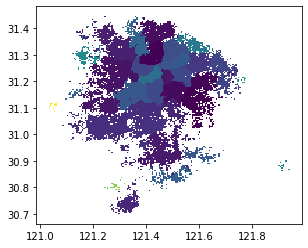

In [15]:
node.plot('group')

这里我们将group字段的分组编号映射到颜色上进行初步可视化，不同分组的颜色不同。从结果的图中可以看到，相同颜色的栅格在地理空间上大多聚集在一起，表明共享单车的空间联系可以将地理空间上接近的区域紧密地联系在一起

前面的结果可视化的效果并不明显，我们并不能从图中清晰地看出分区的情况。接下来，我们可以对分区结果进行一定的调整与可视化。可视化的调整主要有以下思路:

- 比较合适的分区结果应该是每个区域都为空间上连续的区域，在初步的可视化结果中，有不少的栅格在空间上为孤立存在，这些点应该予以剔除。

- 在可视化结果中，我们可以将同一个组别的栅格合并，为每个分区形成面要素，这样在下一步可视化中就可以绘制出分区的边界。

- 在分区结果中，有些区域的内部可能会存在其他区域的“飞地”，即隶属于本分区，却被其他分区所包围，只能“飞”过其他分区的属地，才能到达自己的飞地。这种分区在共享单车的实际运营中也是难以管理的，应该避免这种情况的出现。

解决上述问题，我们可以使用TransBigData所提供的两个GIS处理方法，tbd.merge_polygon和tbd.polyon_exterior。其中tbd.merge_polygon能够将同一个组别的面要素进行合并，而tbd.polyon_exterior则可以对多边形取外边界后再构成新的多边形，以此剔除飞地。同时，也可以设定最小面积，对小于此面积的面要素进行剔除。代码如下

In [16]:
#以group字段为分组，将同一组别的面要素合并
node_community = tbd.merge_polygon(node,'group')
#输入多边形GeoDataFrame数据，对多边形取外边界构成新多边形
#设定最小面积minarea，小于该面积的面全部剔除，避免大量离群点出现
node_community = tbd.polyon_exterior(node_community,minarea = 0.000100)

/opt/anaconda3/lib/python3.8/site-packages/transbigdata/gisprocess.py:263: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for i in p:


处理好社区的面要素后，接下来需要对面要素进行可视化。我们希望对不同的面赋予不同的颜色。在可视化章节中我们提到，在显示的要素没有数值上的大小区别时，颜色的选择上需要保持它们各自的颜色具有相同的亮度与饱和度。而用seaborn的调色盘方法即可快速地生成同一亮度与饱和度下的多种颜色

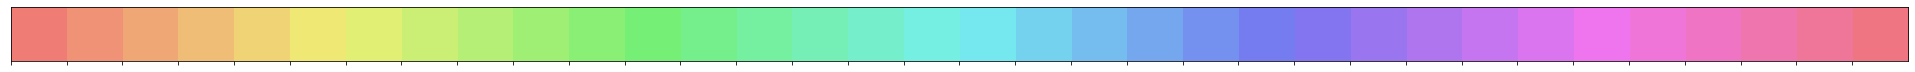

In [17]:
#生成调色盘
import seaborn as sns
## l: 亮度
## s: 饱和度
cmap = sns.hls_palette(n_colors=len(node_community), l=.7, s=0.8)
sns.palplot(cmap)

对社区结果进行可视化

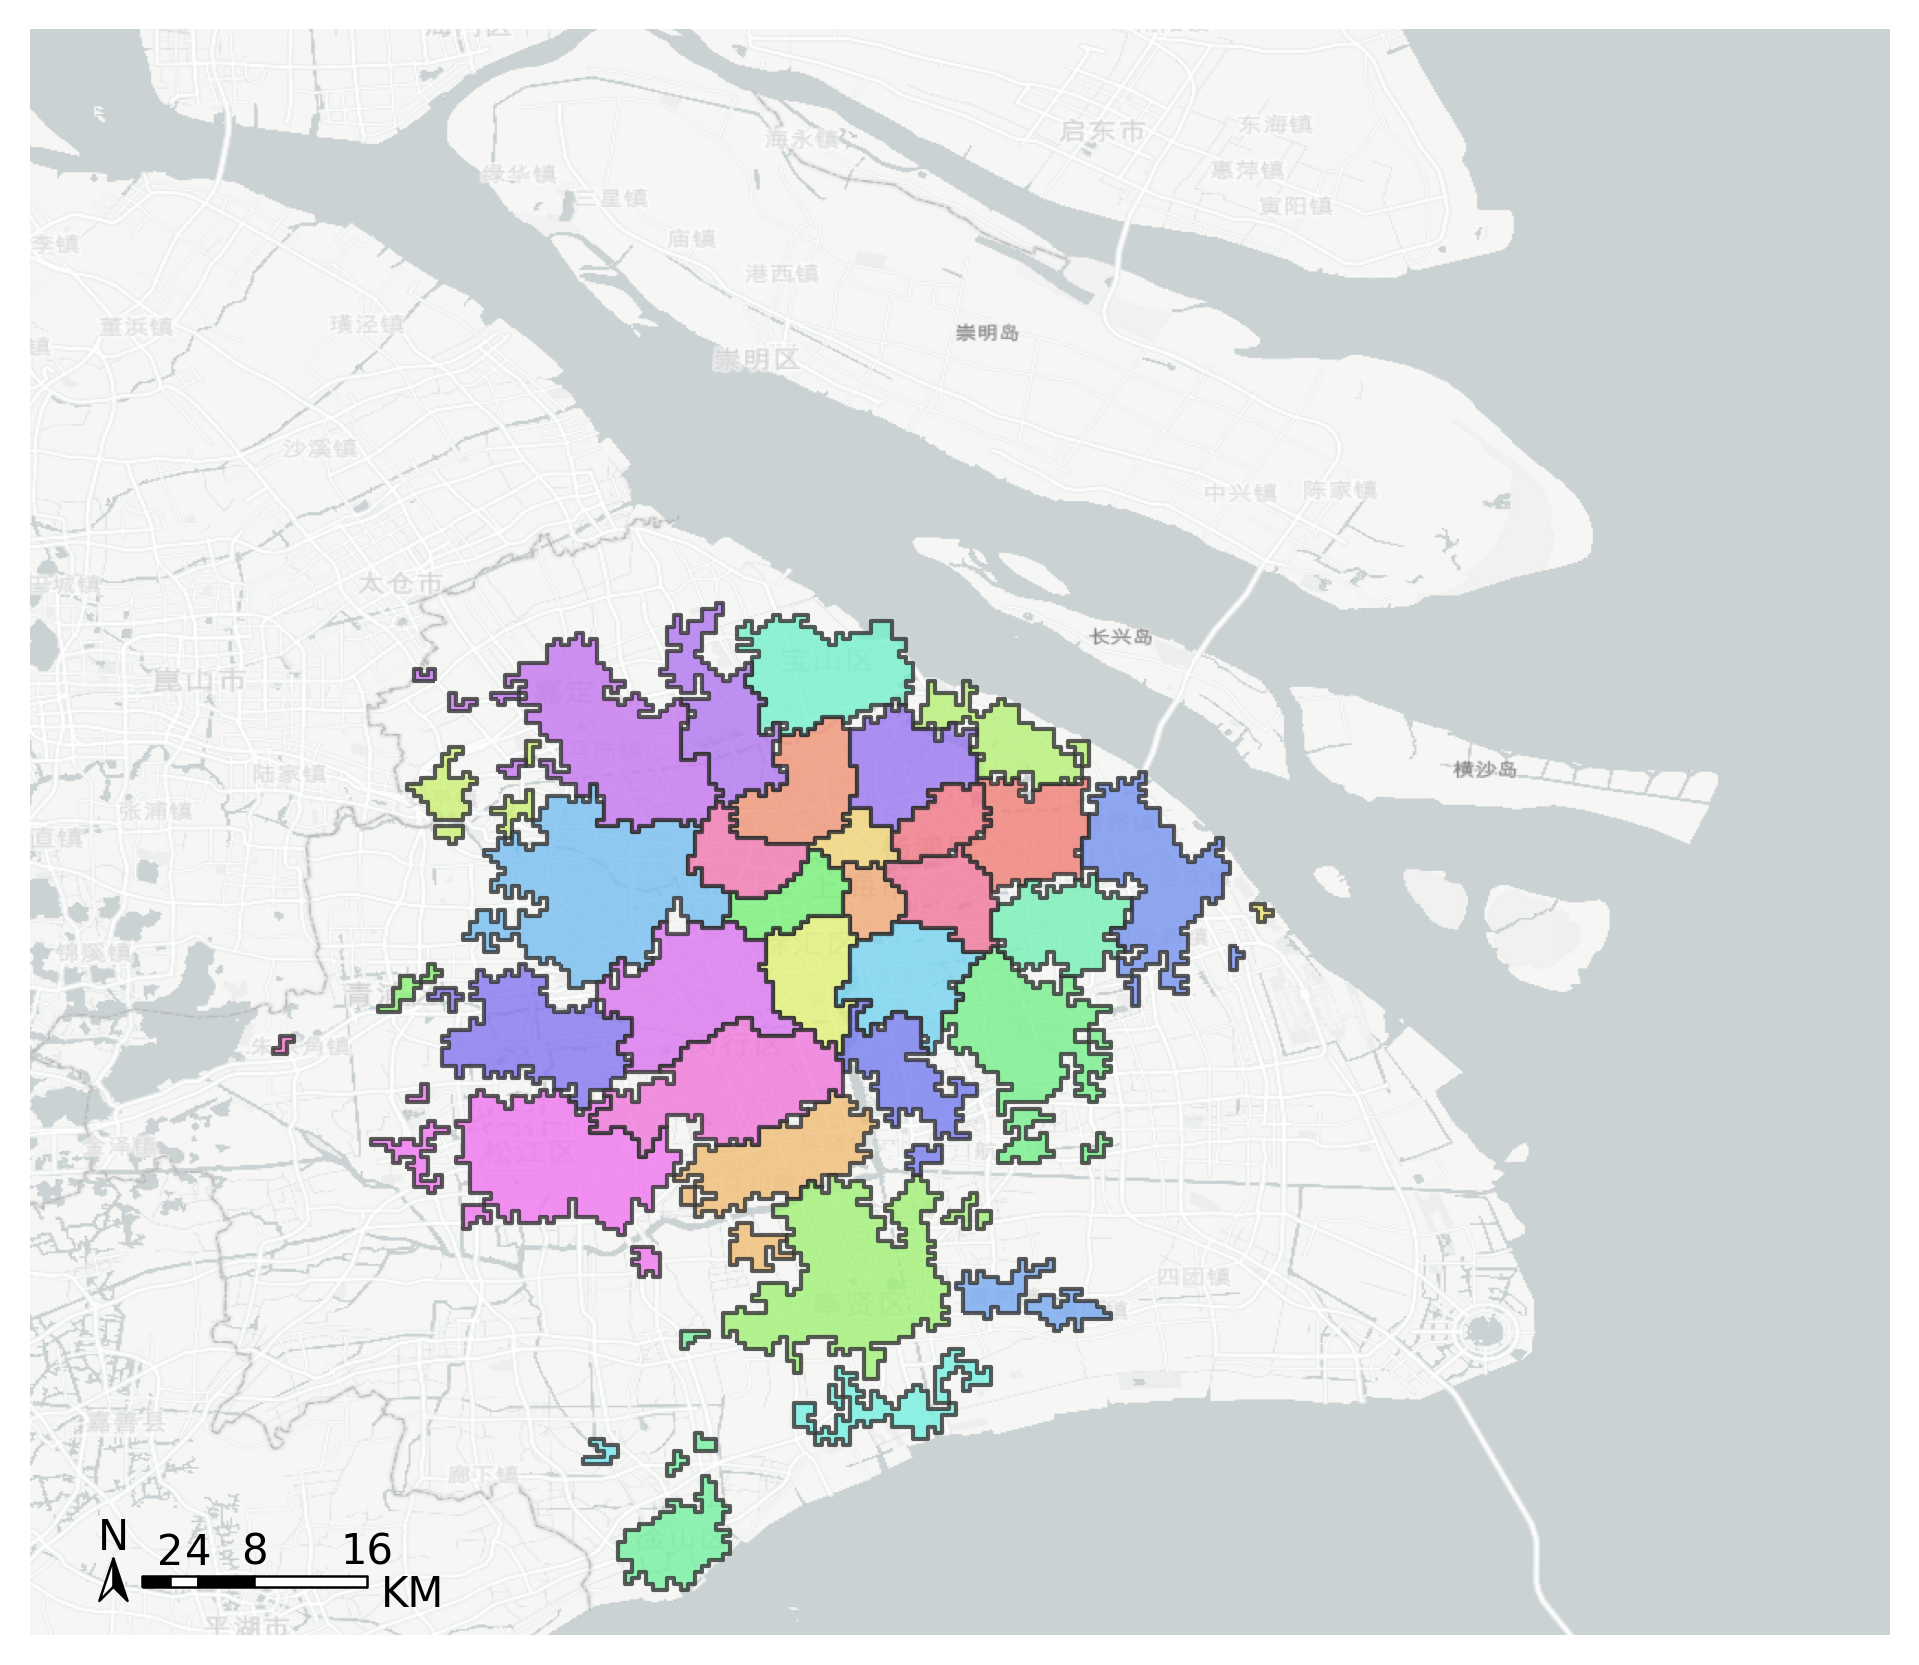

In [18]:
#创建图框
import matplotlib.pyplot as plt
fig =plt.figure(1,(8,8),dpi=300)
ax =plt.subplot(111)
plt.sca(ax)
#添加地图底图
tbd.plot_map(plt,bounds,zoom = 10,style = 6)
#设定colormap
from matplotlib.colors import ListedColormap 
#打乱社区的排列顺序
node_community = node_community.sample(frac=1)
#绘制社区
node_community.plot(cmap = ListedColormap(cmap),ax = ax,edgecolor = '#333',alpha = 0.8)
#添加比例尺和指北针
tbd.plotscale(ax,bounds = bounds,textsize = 10,compasssize = 1,textcolor = 'k'
              ,accuracy = 2000,rect = [0.06,0.03],zorder = 10)
plt.axis('off')
plt.xlim(bounds[0],bounds[2])
plt.ylim(bounds[1],bounds[3])
plt.show()